In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

0


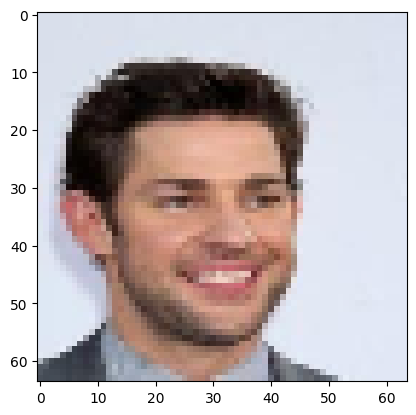

In [4]:
countt=0
image_df = []
for dirname, _, filenames in os.walk('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'):
    for filename in filenames:
#         print(1)
#         print(os.path.join(dirname, filename))
        img_path  = os.path.join(dirname,filename)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(64,64))
        if(countt%50000 ==0):
            print(countt)
            plt.imshow(img)
            plt.show()
        countt+=1
        if(countt==50000):
            break
        
        image_df.append(img)

In [10]:
!pip install gdown
import gdown 
url = 'https://drive.google.com/file/d/1zx7NiObRmuD87xVJLowfrQ-M3AkTKjX5/view?usp=sharing'
output = '/kaggle/working/dataset.npy'
gdown.download(url, output, quiet=True)

'/kaggle/working/dataset.npy'

In [3]:
dff = np.load('/kaggle/working/image_df.npy', allow_pickle=True)
dff.shape

(49999, 64, 64, 3)

In [4]:
image_df = dff

In [5]:
image_df = np.array(image_df)
image_df.shape

(49999, 64, 64, 3)

In [6]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Reshape, UpSampling2D, BatchNormalization
from keras.layers import Conv2D, Flatten, Dropout, LeakyReLU
from keras.utils import plot_model
import numpy as np

In [7]:
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, kernel_size=4, strides=2, padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1024, kernel_size=4, strides=2, padding='same'))
#     model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    opt= Adam(learning_rate=0.0003, beta_1=0.6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 512)         2

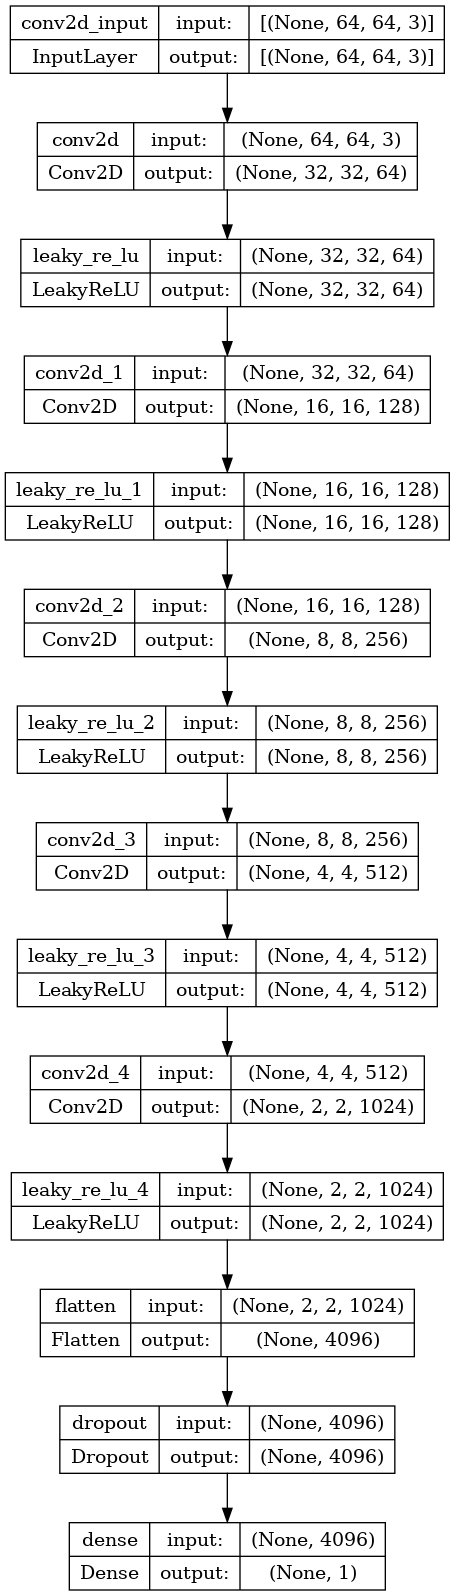

In [8]:
model = define_discriminator()

model.summary()

plot_model(model, to_file='discrim.png', show_shapes=True, show_layer_names=True)

In [9]:
def load_real_samples():
    X = image_df.astype('float32')
    
    #scaling from 0 to 255 -> -1,1
    X = (X-127.5)/127.5
    return X

In [10]:
X = load_real_samples()
print(X.shape)

(49999, 64, 64, 3)


In [11]:
def generate_real_samples(dataset, n_samples):
    # ix is indexes of images selected from dataset
    ix = np.random.randint(0,dataset.shape[0], n_samples)
    X = dataset[ix]
    # y is 1 because all images are real
    y = np.ones((n_samples,1))
    return X, y

In [12]:
def generate_fake_samples(n_samples):
    X = np.random.rand(64*64*3*n_samples)
    X = -1 + X*2
    X = X.reshape((n_samples,64,64,3))
    y = np.zeros((n_samples,1))
    return X,y

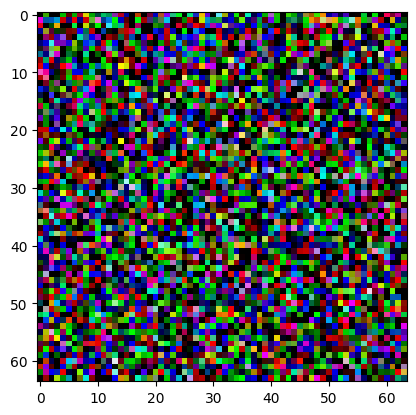

In [13]:
X,y = generate_fake_samples(64)
plt.imshow(X[0])

In [14]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(half_batch)
        
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        print('> %d real=%.0f%% fake=%.0f%%' %(i+1,real_acc*100, fake_acc*100))

In [15]:
model = define_discriminator()

dataset = load_real_samples()

train_discriminator(model,dataset)

> 1 real=61% fake=0%
> 2 real=100% fake=0%
> 3 real=95% fake=100%
> 4 real=95% fake=100%
> 5 real=98% fake=100%
> 6 real=98% fake=100%
> 7 real=100% fake=100%
> 8 real=100% fake=100%
> 9 real=100% fake=100%
> 10 real=98% fake=100%
> 11 real=100% fake=100%
> 12 real=100% fake=100%
> 13 real=100% fake=100%
> 14 real=98% fake=100%
> 15 real=100% fake=100%
> 16 real=100% fake=100%
> 17 real=100% fake=100%
> 18 real=100% fake=100%
> 19 real=100% fake=100%
> 20 real=100% fake=100%


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.utils import plot_model

In [17]:
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 256 * 4*4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # Up sampling to 8x8
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    # Up sampling to 16x16
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    # Up sampling to 32x32
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    # Upsampling to 64x64
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    # Output layer
    model.add(Conv2D(3, kernel_size=4, padding="same", activation='tanh'))

    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 256)         1048832   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                        

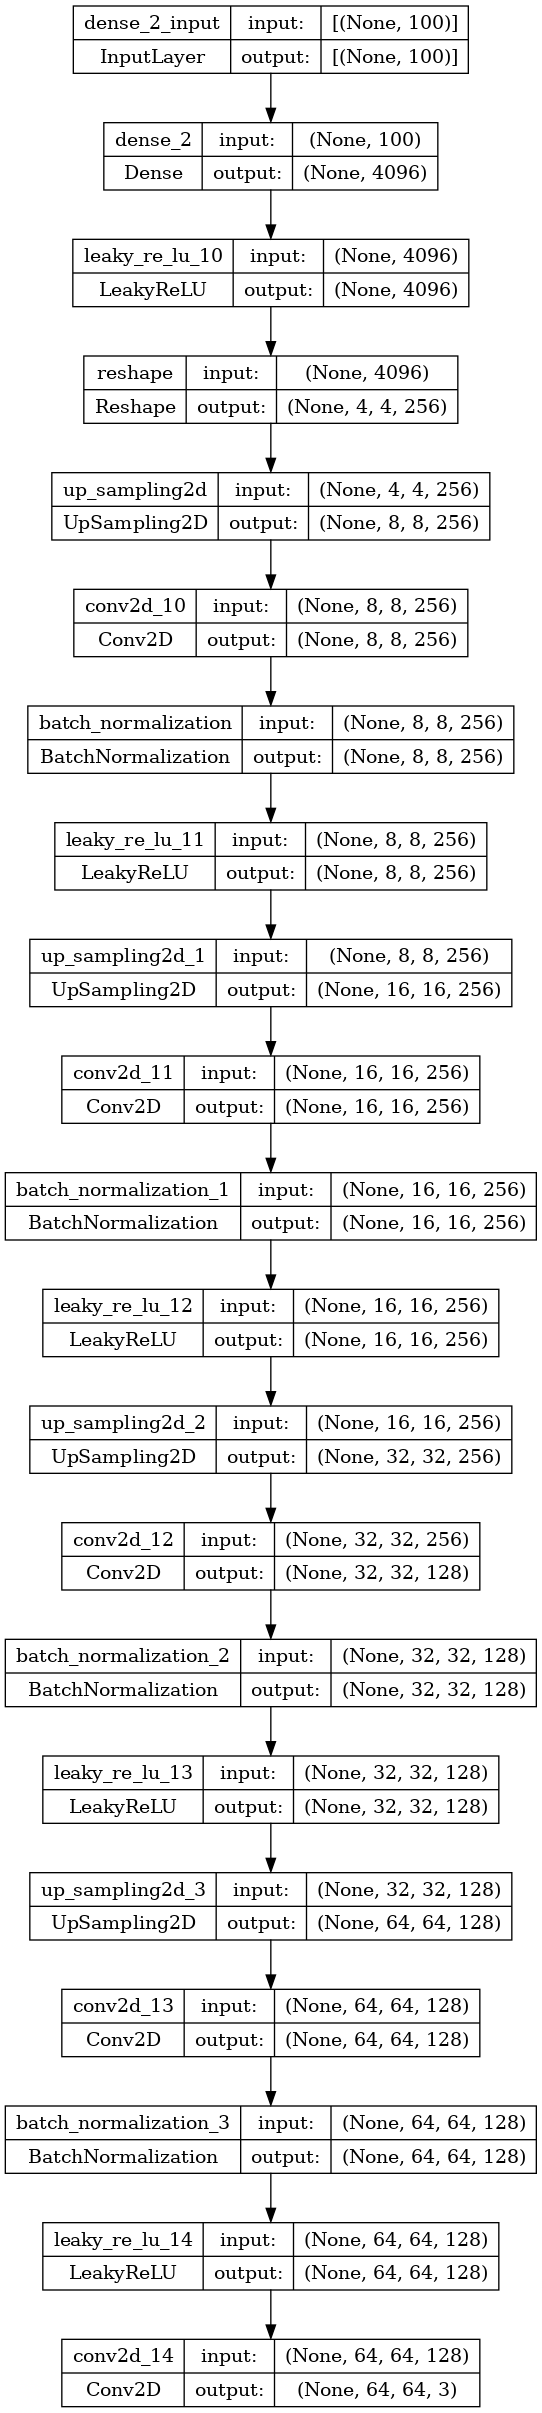

In [18]:
latent_dim=100

model = define_generator(latent_dim)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input

In [20]:
x_input = generate_latent_points(100,64)
x_input.shape

(64, 100)

In [21]:
def generate_fake_samples_gen(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim,n_samples)
    
    X = g_model.predict(x_input)
    
    y=np.zeros((n_samples,1))
    
    return X,y

In [22]:
def define_gan(g_model, d_model):
    d_model.trainable=False
    model = Sequential()
    
    model.add(g_model)
    model.add(d_model)
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64, 64, 3)         3307267   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 11150273  
                                                                 
Total params: 14,457,540
Trainable params: 3,305,731
Non-trainable params: 11,151,809
_________________________________________________________________


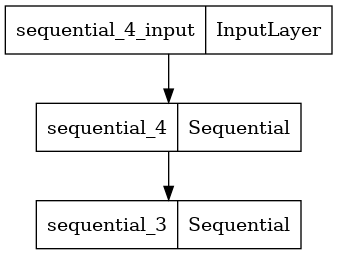

In [23]:
#defining all models and latent dimension
latent_dim=100
d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

gan_model.summary()
plot_model(gan_model)

In [24]:
def save_plot(examples, epoch, n=3):
    examples = (examples+1)/2.0
    
    for i in range(n*n):
        plt.subplot(n,n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i])
    
    filename = 'generated_%03d.png'%(epoch+1)
    plt.savefig(filename)
    plt.close

In [25]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, 64)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples_gen(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('> Accuracy real: %.0f%%, fake: %.0f%%' %(acc_real*100, acc_fake*100))
    
    save_plot(x_fake, epoch)
    filename = 'generator_%03d.h5'%(epoch+1)
    g_model.save(filename)
    filename = 'discriminator_%03d.h5'%(epoch+1)
    d_model.save(filename)
    filename = 'GANmodel_%03d.h5'%(epoch+1)
    g_model.save(filename)

In [26]:
def train(g_model, d_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch/2)
    
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples_gen(g_model, latent_dim, half_batch)
            
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch,1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print('> %d %d/%d dloss_real=%.3f dloss_fake=%.3f gloss=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            
        if(i+1)%1 ==0:
            summarize_performance(i,g_model, d_model, dataset, latent_dim)

2/2 [==============================] - 1s 5ms/step
> 1 1/390 dloss_real=0.695 dloss_fake=0.729 gloss=0.577
2/2 [==============================] - 0s 27ms/step
> 1 2/390 dloss_real=0.402 dloss_fake=1.035 gloss=0.280
2/2 [==============================] - 0s 27ms/step
> 1 3/390 dloss_real=0.096 dloss_fake=0.925 gloss=0.310
2/2 [==============================] - 0s 27ms/step
> 1 4/390 dloss_real=0.088 dloss_fake=0.727 gloss=2.959
2/2 [==============================] - 0s 27ms/step
> 1 5/390 dloss_real=0.219 dloss_fake=4.795 gloss=2.524
2/2 [==============================] - 0s 27ms/step
> 1 6/390 dloss_real=0.776 dloss_fake=0.412 gloss=2.175
2/2 [==============================] - 0s 27ms/step
> 1 7/390 dloss_real=0.971 dloss_fake=1.589 gloss=2.294
2/2 [==============================] - 0s 27ms/step
> 1 8/390 dloss_real=0.570 dloss_fake=0.168 gloss=3.401
2/2 [==============================] - 0s 27ms/step
> 1 9/390 dloss_real=0.353 dloss_fake=0.011 gloss=2.110
2/2 [========================

KeyboardInterrupt: 

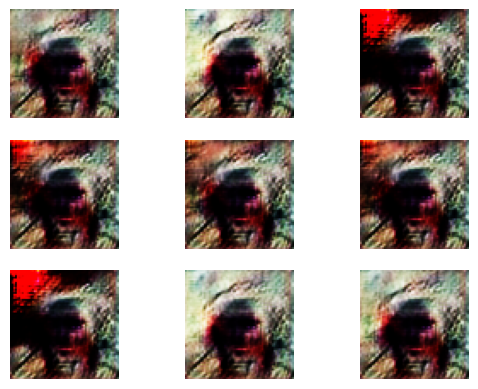

In [27]:
train(g_model, d_model, dataset, latent_dim, n_epochs=100, n_batch=128)

5/5 [==============================] - 0s 42ms/step
> Accuracy real: 92%, fake: 100%


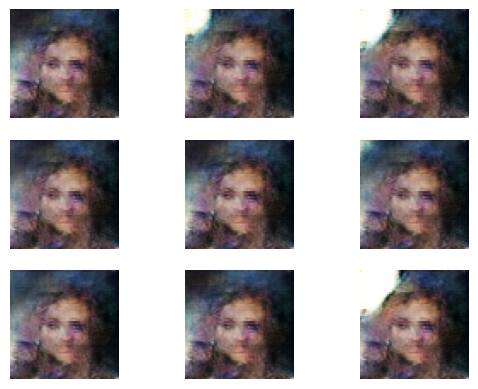

In [31]:
summarize_performance(0,g_model, d_model, dataset, latent_dim)

In [29]:
np.save('image_df.npy',image_df)

313/313 [==============================] - 10s 33ms/step


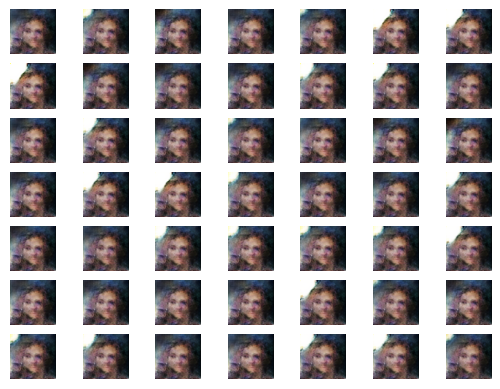

In [37]:
xf, yf = generate_fake_samples_gen(g_model, 100, 10000)
save_plot(xf,0,7)

32/32 [==============================] - 1s 34ms/step


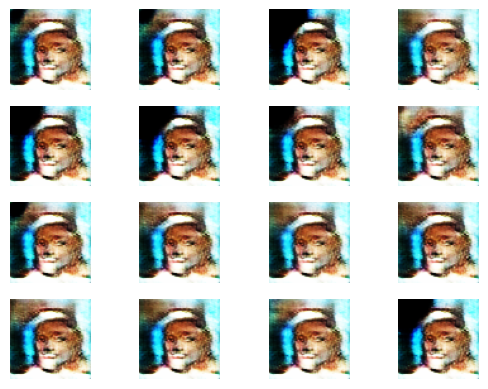

In [43]:
from tensorflow.keras.models import load_model
modell = load_model('generator_023.h5')
xf, yf = generate_fake_samples_gen(modell, 100, 1000)
save_plot(xf,0,4)